# San Francisco Crime Classification

For this project, we will try to predict the type of crime that occurrred in San Francisco using only time and location data.

The data comes from a previous Kaggle competition (https://www.kaggle.com/c/sf-crime/data). We will be using the "train.csv" file.

In [2]:
%matplotlib inline

In [7]:
import holidays
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'imblearn'

In [6]:
crime = pd.read_csv('data/train.csv', parse_dates=['Dates'])

## Load and inspect the data

In [8]:
# Convert str cols to categories if reasonable.
print(f"{'Feature':<15} Number of Unique Values" + '\n')
for col_name in crime.select_dtypes('object'):
    num_unique = crime[col_name].unique().size
    print(f'{col_name:<15} {num_unique}')
    if num_unique < 50:
        crime[col_name] = crime[col_name].astype('category')

Feature         Number of Unique Values

Category        39
Descript        879
DayOfWeek       7
PdDistrict      10
Resolution      17
Address         23228


In [9]:
crime.head(3)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414


In [10]:
print(f"{'Feature':<15} Null Values" + '\n')
for col_name in crime:
    print(f'{col_name:<15} {crime[col_name].isnull().sum()}')

Feature         Null Values

Dates           0
Category        0
Descript        0
DayOfWeek       0
PdDistrict      0
Resolution      0
Address         0
X               0
Y               0


In [11]:
print(f"{'# of crime categories:':>15} {crime.Category.unique().size}")

# of crime categories: 39


In [12]:
print("Categories that made up more than 5% of crimes:")
cat_counts = crime.Category.value_counts(normalize=True)
cat_counts[cat_counts.values > .05]

Categories that made up more than 5% of crimes:


LARCENY/THEFT     0.199192
OTHER OFFENSES    0.143707
NON-CRIMINAL      0.105124
ASSAULT           0.087553
DRUG/NARCOTIC     0.061467
VEHICLE THEFT     0.061251
VANDALISM         0.050937
Name: Category, dtype: float64

# Process the data

There are 39 crime categories in the original data. We want to focus our analysis on three broader "types" of crimes that are of interest to a San Francisco resident: theft, violent crime, and deviant behavior. We will drop and re-group the original categories accordingly.

In [13]:
def process_labels(df):
    """Clean up labels and drop un-used categories. Group data into three
    major categories: Violent crime, deviant behavior, and theft (the most
    common type of crime)."""
    df['Category'] = df.Category.replace('TREA', 'TRESPASS')
    drop = ["NON-CRIMINAL", "MISSING PERSON",
        "SUSPICIOUS OCC", "SUICIDE", "RECOVERED VEHICLE", "OTHER OFFENSES",
        "BAD CHECKS", "BRIBERY", "EMBEZZLEMENT", "EXTORTION", 
        "FAMILY OFFENSES", "GAMBLING", "PORNOGRAPHY/OBSCENE MAT", 
        "SECONDARY CODES", "SEX OFFENSES NON FORCIBLE", "ARSON",
        "DISORDERLY CONDUCT", "DRIVING UNDER THE INFLUENCE", "WEAPON LAWS", 
        "LIQUOR LAWS", "LOITERING","RUNAWAY","WARRANTS",
        "FORGERY/COUNTERFEITING","KIDNAPPING","FRAUD","VANDALISM"]
    df = df[~df.Category.isin(drop)]
    df['Category'] = df.Category.replace(["ASSAULT",'SEX OFFENSES FORCIBLE'],
                                         "violent")
    df['Category'] = df.Category.replace(["DRUG/NARCOTIC",'DRUNKENNESS', 
                                          "PROSTITUTION"], "deviant")
    df['Category'] = df.Category.replace(["BURGLARY",'LARCENY/THEFT', 
                                          "STOLEN PROPERTY", "TRESPASS", 
               "ROBBERY", "THEFT", "VEHICLE THEFT"], "theft")
    return df

We also need to extract information from some the feature columns, such as "Dates", for EDA and visualization.

In [14]:
def feature_dates(df):
    """Add categorical feature showing part of day."""
    labels = ['Night', 'Morning', 'Afternoon', 'Evening']
    df['Daypart'] = pd.cut(df.Dates.dt.hour, bins=4, labels=labels)
    df['Hour'] = df.Dates.dt.hour
    df['Month'] = df.Dates.dt.month
    df['Day'] = df.Dates.dt.day
    return df

In [15]:
def feature_holiday(df):
    """Add boolean feature showing if crime occurred on a holiday."""
    us_holidays = [date.strftime('%m-%d-%Y') for date in 
               list(holidays.US(years=range(2003, 2016)).keys())]
    df['Dt'] = pd.to_datetime(df['Dates'].dt.date)
    df['Is_Holiday'] = np.where(df['Dt'].isin(us_holidays), 1, 0)
    df = df.drop(columns='Dt', axis=1)
    return df

In [16]:
def feature_corner(df):
    """Add boolean feature showing if location was at a street corner."""
    df['Is_Corner'] = np.where(df['Address'].str.contains("/"), 1, 0)
    return df

In [17]:
def feature_resolved(df):
    """Add feature showing if crime was resolved."""
    df['Is_Resolved'] = np.where(df['Resolution'] != "NONE", 1, 0)
    return df

In [18]:
def process_features(df, funs=[feature_dates, feature_holiday, 
                              feature_corner, feature_resolved]):
    """Process all features."""
    for fun in funs:
        df = fun(df)
    return df

In [19]:
def process_data(df):
    """Process labels first so features are only created for rows being kept.
    """
    df = process_labels(df)
    df = process_features(df)
    return df

In [20]:
def feature_dummies(df):
    """Convert categorical vars to dummies."""
    cols = ['DayOfWeek', 'PdDistrict', 'Daypart', 'Hour', 'Month', 'Day']
    for col in cols:
        df = pd.concat((df, pd.get_dummies(df[col], prefix=col)), axis=1)
        df = df.drop(columns=col)
    return df

In [21]:
crime_clean = process_data(crime)

/Users/wendy.x/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/wendy.x/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/wendy.x/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [40]:
crime_clean.shape

(447307, 16)

In [23]:
del crime

In [24]:
feature_idx = np.r_[0, 3:5, 7:16]
X = crime_clean.iloc[:, feature_idx]
y = crime_clean['Category']

## Train/Test Split
Before fitting models, we want to get some sense of the data. We split it into
train and test sets first to avoid data leakage. (Note that while random variability 
is an important part of the model fitting process, this is one area that requires
reproducability, so a random state is used.) The dataset is large enough that a
90/10 train/test split is reasonable.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [26]:
for df in [X_train, X_test, y_train, y_test]:
    print(df.shape)

(402576, 12)
(44731, 12)
(402576,)
(44731,)


## Explore and visualize the training data

First, let's take a look at the three crime categories.

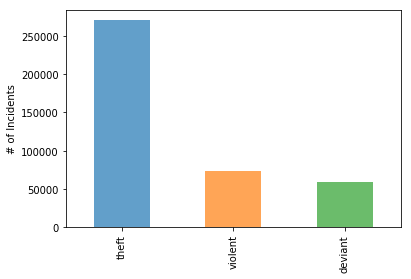

In [27]:
categories = ['theft', 'violent', 'deviant']
category_counts = y_train.value_counts(sort=True)
category_counts.plot.bar(alpha=.7)
plt.ylabel('# of Incidents')
plt.show()

We see that the classes we're trying to predict are imbalanced, with far more incidents for theft than for violent and deviant. This is something to keep in mind when we do our modeling.

### Explore time variables

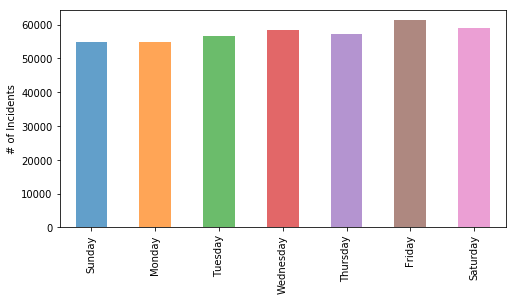

In [28]:
weekdays = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
            'Saturday']
weekday_counts = X_train.DayOfWeek.value_counts(sort=False)
sorted_counts = pd.Series([weekday_counts[day] for day in weekdays])
sorted_counts.plot.bar(alpha=.7, figsize=(8, 4))
plt.xticks(ticks=range(7), labels=weekdays)
plt.ylabel('# of Incidents')
plt.show()

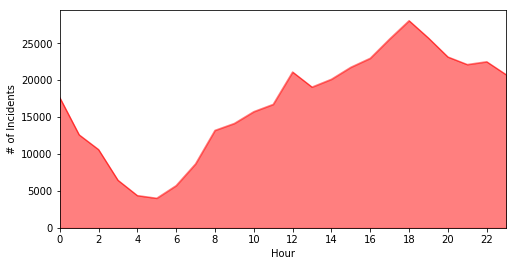

In [29]:
hour_counts = X_train.Dates.dt.hour.value_counts(sort=False)
hour_counts.plot(kind='area', alpha=.5, color='red', figsize=(8, 4))
plt.xlim(0, 23)
plt.xticks(range(0, 24, 2))
plt.xlabel('Hour')
plt.ylabel('# of Incidents')
plt.show()

We are curious which time variable(s) are useful predictors of Category.

In [30]:
train = pd.concat((X_train, y_train), axis=1)

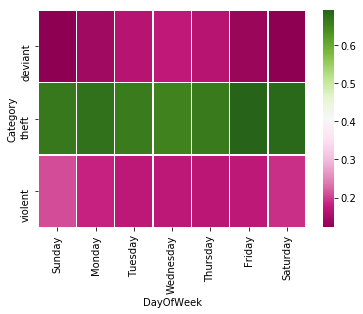

In [31]:
dow_type = train.groupby(['DayOfWeek', 'Category']).size().reset_index()
dow_type.columns = ['DayOfWeek', 'Category', 'Count']
dow_type = dow_type.pivot(index='Category', columns='DayOfWeek', values='Count')
dow_type = dow_type[["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]]
dow_type = dow_type.div(dow_type.sum(axis=0), axis=1)
ax = sns.heatmap(dow_type, linewidths=.5, cmap="PiYG")

From the heatmap, there is not much variability in the proportion of each Category across weekdays. How about across time of day?

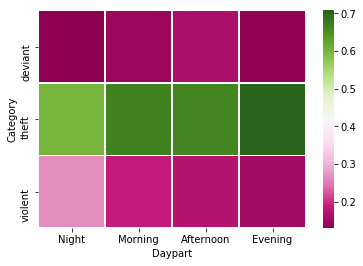

In [32]:
daypart_type = train.groupby(['Daypart', 'Category']).size().reset_index()
daypart_type.columns = ['Daypart', 'Category', 'Count']
daypart_type = daypart_type.pivot(index='Category', columns='Daypart', values='Count')
daypart_type = daypart_type.div(daypart_type.sum(axis=0), axis=1)
sns.heatmap(daypart_type, linewidths=.5, cmap="PiYG")

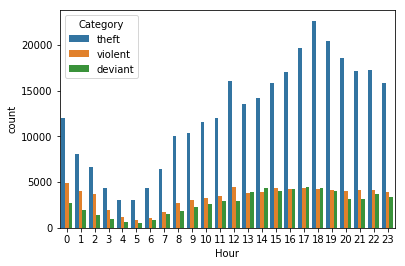

In [123]:
sns.countplot(x="Hour", hue="Category", data=crime_clean)
# this might help intuitively?

There is more variability across time of day. For example, the proportion of violent crime (out of all incidents) is slightly higher during night time.

For each crime category, about 3% of incidents occured on a holiday:

In [33]:
train.pivot_table(values='Is_Holiday', index='Category', 
                  aggfunc=['sum', 'mean'])

,sum,mean
,Is_Holiday,Is_Holiday
Category,,
deviant,1753,0.029637
theft,8346,0.030884
violent,2461,0.033625


### Explore location variables

Plot incidents by Police District (http://sanfranciscopolice.org/sites/default/files/Citywide_District_Map.pdf):

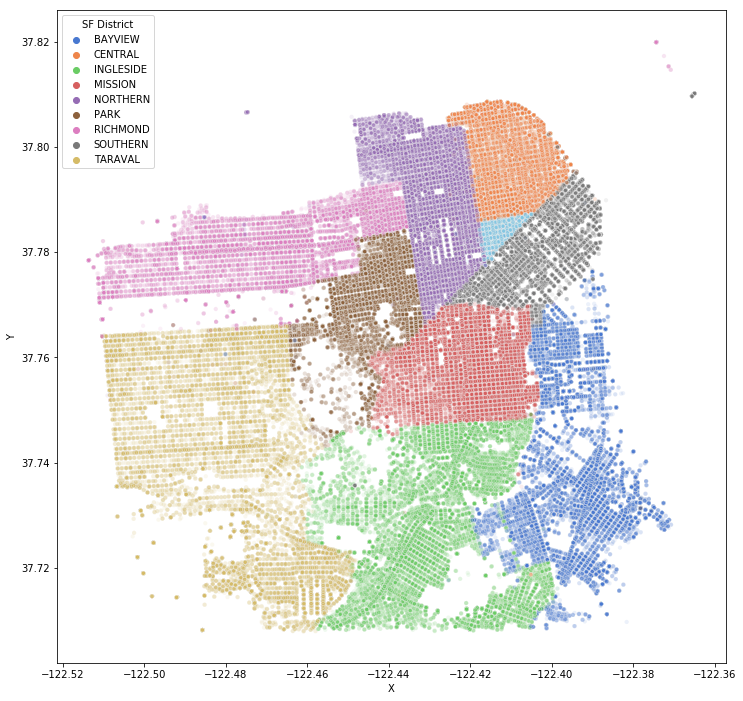

In [79]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(x='X', y='Y', data=X_train[X_train.Y < 40], hue='PdDistrict',
          palette='muted', size=.01, alpha=0.1, ax=ax)
ax.legend(ax.get_legend_handles_labels()[0][1:10], ax.get_legend_handles_labels()[1][1:10], title='SF District')
plt.show()

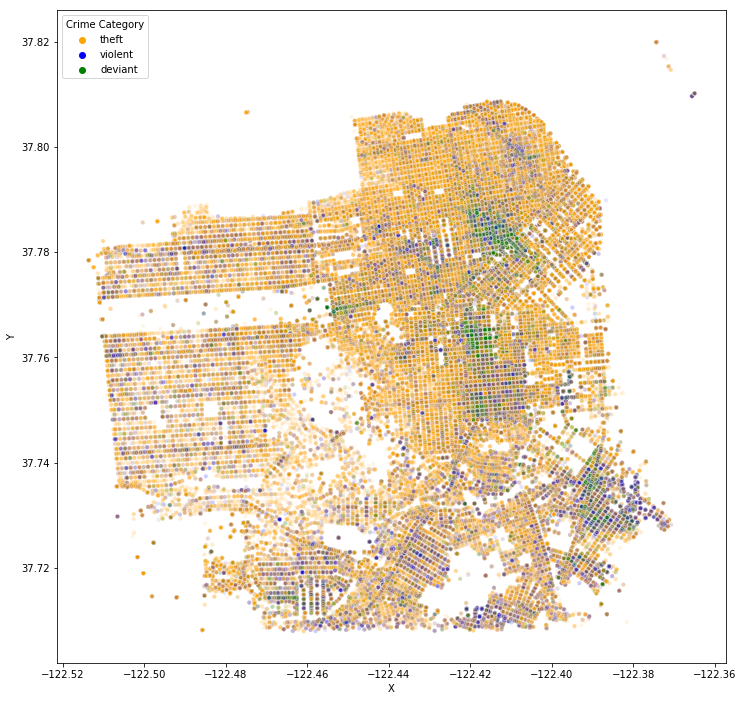

In [118]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(x='X', y='Y', data=crime_clean[crime_clean.Y < 40], hue='Category', 
                palette={'theft':'Orange','violent':'blue','deviant':'Green'}, size=.01, alpha=0.1, ax=ax)
ax.legend(ax.get_legend_handles_labels()[0][1:4], ax.get_legend_handles_labels()[1][1:4], title='Crime Category')
plt.show()

We will check if proprtion of each crime Category varies by district. We see below that the proprtion of deviant crimes (drugs, drunkenness, prostitution) out of all incidents is higher in the Tenderloin district, but otherwise do not seem to vary much.

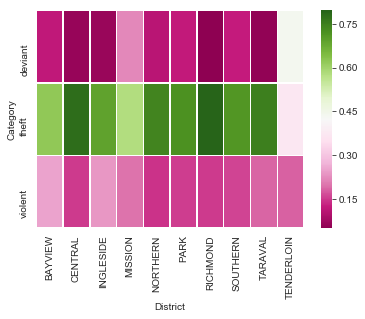

In [32]:
district_type = train.groupby(['PdDistrict', 'Category']).size().reset_index()
district_type.columns = ['District', 'Category', 'Count']
district_type = district_type.pivot(index='Category', columns='District', values='Count')
district_type = district_type.div(district_type.sum(axis=0), axis=1)
sns.heatmap(district_type, linewidths=.5, cmap="PiYG")

However, the percent of all incidents that occur at a street corner does vary across the crime categories. This suggests that Is_Corner will be a useful feature for modeling.

In [33]:
train.pivot_table(values='Is_Corner', index='Category', 
                  aggfunc=['sum', 'mean'])

,sum,mean
,Is_Corner,Is_Corner
Category,,
deviant,24544,0.414952
theft,79889,0.295626
violent,14544,0.198716


Lastly, one feature we considered using is whether an incident was resolved. In the end, we decided not to because doing it is using future information to predict the past.

However, it would have been a useful predictor because Is_Resolved differs dramatically between the three categories.

In [34]:
train.pivot_table(values='Is_Resolved', index='Category', 
                  aggfunc=['sum', 'mean'])

,sum,mean
,Is_Resolved,Is_Resolved
Category,,
deviant,54062,0.913997
theft,38961,0.144173
violent,30811,0.420973


## Prepare the data for modeling

In [35]:
# Encode categorical features as dummies

X_train = feature_dummies(X_train).drop(columns=['Dates', 'Is_Resolved'])
X_test = feature_dummies(X_test).drop(columns=['Dates', 'Is_Resolved'])

In [36]:
# Rename to Lat and Long to avoid confusion
X_train = X_train.rename(columns = {'X':'Long', 'Y':'Lat'})
X_test = X_test.rename(columns = {'X':'Long', 'Y':'Lat'})

## Evaluation Metric

We want a single metric to guide the model selection process that would account for the imbalanced classes in our data. Accuracy is not appropriate because it rewards predicting the most frequent class. In the context of our research question, we don't favor one of Precision or Recall over the other, so we will weight them equally and use F1 score (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html).

However, since our task is classifying into multiple categories (and not simple binary classification), we need to a way to weight the F1 scores for each class to produce a single metric.
- We decided not use F1-micro because it is the same as accuracy in this particular context. 
- F1-macro over-corrected for class imbalance by completely ignoring the number of instances in each class.
- We settled on something in the middle: F1-weighted. It gives some weight to the most frequent class without allowing it to dominate.

We will use the F1-weighted score in cross-validation to guide the model selection process. We will then present the F1-weighted of the best model applied our test set, as well as individual scores for each class and a confusion matrix.

## Naive Bayes

Almost all of our features are categorical, so we need to select an appropriate algorithm. We will fit Naive Bayes (specifically the Bernoulli variant) as our initial model because it is suitable for this kind of data.

In [37]:
clf_nb = BernoulliNB()

# Exclude Lat and Long from the model
clf_nb.fit(X_train.ix[:,2:], y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [38]:
cv_scores = cross_val_score(clf_nb, X_train.ix[:,2:], y_train, scoring='f1_weighted', cv=5)

print(f"Mean CV f1_weighted: {cv_scores.mean():,.4f}")

Mean CV f1_weighted: 0.6076


Let's see if we can improve performance by tuning Naive Bayes's additive smoothing parameter:

In [39]:
params = dict(alpha=np.linspace(0, 2, 5))

In [40]:
nb_gs = GridSearchCV(BernoulliNB(), param_grid=params, scoring='f1_weighted', cv=5)

In [41]:
nb_gs.fit(X_train.ix[:,2:], y_train)

In [43]:
print(f"The best hyperparameters are {nb_gs.best_params_}. Its associated f1_weighted is {nb_gs.best_score_:,.4f}")

The best hyperparameters are {'alpha': 0.5}. Its associated f1_weighted is 0.6076


In [ ]:
nb_gs.best_params_, nb_gs.best_score_

### Naive Bayes with resampling

Unfortunately the "best" hyperparameters did not actually result in better performance.

Next we will explore improving performance through resampling because our data has imbalanced classes. Since the majority class (theft) is 4-5 times the size of the minority classes, we will over-sample "violent" and "deviant" and do so in a pipeline.

In [60]:
ros_nb_pipe = Pipeline([('ros', RandomOverSampler()), ('clf_nb', BernoulliNB())])

In [61]:
cv_scores = cross_val_score(ros_nb_pipe, X_train.ix[:,2:], y_train, scoring='f1_weighted', cv=5)

print(f"Mean CV f1_weighted: {cv_scores.mean():,.4f}")

Mean CV f1_weighted: 0.5343


Resampling actually resulted in worse performance. This may be because the model was trained on balanced classes (after over-sampling), but scored on its performance on the original imbalanced data.

In the context of our research question, imbalanced classes is a feature and not a bug. The reality is that theft just occurs more often in the real-world than violent crime and deviant behavior.

## Random Forest

We will now fit a RandomForest model using scikit-learn default hyperparameters and see how its performance compares.

### Random Forest without Lat/Long

In [69]:
rf = RandomForestClassifier(n_jobs=-1)

cv_scores = cross_val_score(rf, X_train.ix[:,2:], y_train, scoring='f1_weighted', cv=5)
print(f"Mean CV f1_weighted: {cv_scores.mean():,.4f}")

Mean CV f1_weighted: 0.7100


### Random Forest with Lat/Long

### ? Random Forest hyperparameter tuning

In [77]:
grid_params = dict()

gs = GridSearchCV(estimator=rf, param_grid=grid_params, n_jobs=-1, scoring='f1_weighted', cv=5)

gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [10, 50]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='f1_weighted',
       verbose=0)

In [79]:
gs.best_params_, gs.best_score_

({'n_estimators': 50}, 0.7213574359473087)

# Model comparison and selection

Graph of cross_val scores

# Final model interpretation

Visualize Random Forest

Show most important features

# Final model evaluation

Test set f1_weighted

Confusion matrix

? Precison/Recall curves

### Compare to chance performance

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score

In [ ]:
f1_score(y_test, y_predicted, average="weighted")

In [ ]:
y_chance = ['theft' for i in range(y_test.shape[0])]

In [ ]:
f1_score(y_test, y_chance, average="weighted")